In [1]:
import collections
import pathlib
import random
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io
from skimage import color

import mahotas
import mahotas.demos
from pylab import gray, imshow, show



import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time

from torchvision.transforms import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import glob
import random
from torch.utils.data import Dataset
from PIL import Image
import sys
import torch
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter


import torchvision
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#Extracting the palette

#Reading Paintings
path = '/Users/arpit/Desktop/GAN/Paintings100/*.jpg'
filenames = [img for img in glob.glob(path)]
filenames.sort()
#Reading Generated Paintings
path_1 = '/Users/arpit/Desktop/GAN/GeneratedPaintings100/*.png'
filenames_1 = [img for img in glob.glob(path_1)]
filenames_1.sort()
# Monet Palette
mp_palette = []
for name in filenames:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Monet Palette Dominant color is: BGR ({})'.format(centers[0].astype(np.int32)))
    mp_palette.append(centers[0].astype(np.int32))
    
#Generated Monet Palette
gen_palette = []
for name in filenames_1:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Generated Monet Palette Dominant color is: BGR({})'.format(centers[0].astype(np.int32)))
    gen_palette.append(centers[0].astype(np.int32))
rgb_pal = [i[[2,1,0]] for i in mp_palette]
X = [i/255 for i in rgb_pal]

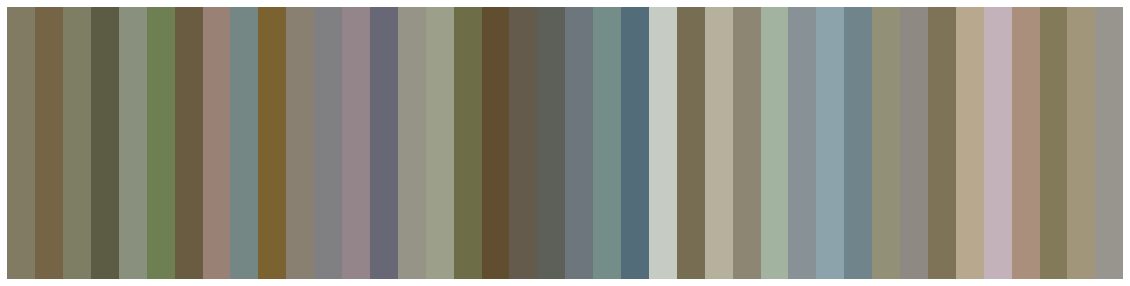

In [3]:
#Palette
scaled_colours = [[color / 255 for color in row] for row in rgb_pal]
#scaled_colours = [[color for color in row] for row in X]
fig, ax = plt.subplots(figsize=(20, 5))
title = "Palette"
#creating bar image
cols = len(scaled_colours)
rows = max([1,int(cols/2.5)])

# Create color Array
barFullData = np.tile(scaled_colours, (rows,1)).reshape(rows, cols, 3)
# Create Image from Array
barImg = Image.fromarray(barFullData, 'RGB')


ax.axis(xmin=0, xmax=len(barFullData))
ax.axis('off')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for index, colour in enumerate(scaled_colours):
    ax.axvspan(index, index + 1, color=colour)
    ax.patch.set_visible(False)

/Users/arpit/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


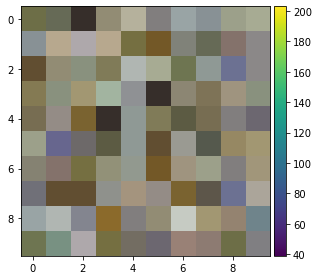

In [4]:
m, n = 10, 10
temp_p = np.array(rgb_pal)
indices = np.random.randint(0, len(temp_p), size=(m, n))
io.imshow(temp_p[indices])

In [5]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [6]:
class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)
    
    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        #print('Feature Encoder C4: ', c4.shape)
        c3 = self.res1(c4)
        #print('Feature Encoder C3: ', c3.shape)
        c2 = self.res2(c3)
        #print('Feature Encoder C2: ', c2.shape)
        c1 = self.res3(c2)
        #print('Feature Encoder C1: ', c1.shape)
        return c1, c2, c3, c4

In [7]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    ) 
class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up_4 = double_conv(300 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(300 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(300 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1) 
        
        
    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 ", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:2 ", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:3 ", target_palettes.shape )

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        #print('X1 shape after Cat C1:', x.shape)
        x = self.dconv_up_4(x)
        #print('X1 shape after deconv C1:', x.shape)
        x = self.upsample(x)
        #print('X1 shape after upsample C1:', x.shape)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        #print('X2 shape after Cat C2:', x.shape)
        x = self.dconv_up_3(x)
        #print('X2 shape after deconv C2:', x.shape)
        x = self.upsample(x) 
        #print('X2 shape after upsample C2:', x.shape)

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 for c3", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:reshape and mul pal for c3", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:reshape for c3", target_palettes.shape )
        x = torch.cat([target_palettes.float(), c3, x], dim=1)   
        #print('X1 shape after Cat C3:', x.shape)
        x = self.dconv_up_2(x)
        #print('X1 shape after deconv C3:', x.shape)
        x = self.upsample(x)  
        #print('X1 shape after upsample C3:', x.shape)

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 for c4", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:reshape and mul pal for c4", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:reshape for c4", target_palettes.shape )
        x = torch.cat([target_palettes.float(), c4, x], dim=1) 
        #print('X1 shape after Cat C4:', x.shape)
        x = self.dconv_up_1(x)
        #print('X1 shape after deconv C4:', x.shape)
        x = self.upsample(x)  
        #print('X1 shape after upsample C4:', x.shape)

        
        
        #print(x.shape)
        #May be error
        #print('Before illu shape: ',illu.shape)
        illu = illu.view(1, 1,illu.size(1),illu.size(0) )
        #print('After illu shape: ',illu.shape)
        x = torch.cat((x, illu), dim = 1)
        #print('X shapen with x and illu: ',illu.shape)
        x = self.conv_last(x)
        #print('X shape with x: ',x.shape)
        return x

In [8]:
temp_six = np.array(rgb_pal)

In [9]:
def rgb2lab(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)


def lab2rgb(lab):
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

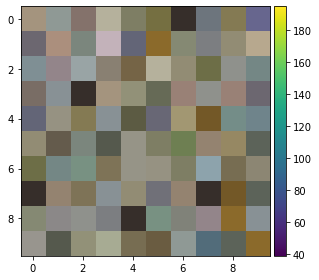

In [10]:
m, n = 10, 10
indices = np.random.randint(0, len(temp_six), size=(m, n))
io.imshow(temp_six[indices])

In [11]:
t_lab = []
for i in temp_six:
    t_lab.append(cv2.cvtColor(np.uint8([[i]]), cv2.COLOR_RGB2LAB)[0][0])

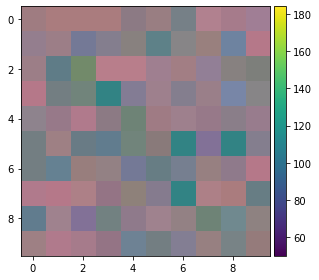

In [12]:
m, n = 10, 10
lab_f= np.array(t_lab)
indices = np.random.randint(0, len(lab_f), size=(m, n))
io.imshow(lab_f[indices])

In [13]:
t_rgb = []
for i in t_lab:
    t_rgb.append(cv2.cvtColor(np.uint8([[i]]), cv2.COLOR_LAB2RGB)[0][0])

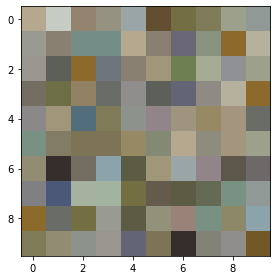

In [14]:
m, n = 10, 10
tt = np.array(t_rgb)
indices = np.random.randint(0, len(tt), size=(m, n))
io.imshow(tt[indices])

In [15]:
lab_flat = lab_f.flatten()

In [16]:
flat_pal = torch.from_numpy(lab_flat).double()

In [17]:
flat_pal.shape

torch.Size([300])

In [18]:
def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    
    
    #print('Initial: ', img.shape)
    img = img[0]
    #img = img.astype(np.float) * 255
    #plt.imshow('Lab Illu: ', img)
    #print(img.shape)
    img = img.permute(1, 2, 0)  # (h, w, channel) 
    #print('img: no mul ',img)
    img = img.numpy()
    #print(img)
    #print(img.shape)
    #plt.imshow('Lab Illu: ', img*255)
    #print('img: ',img)
    #print('After No Dividing mul 255 : ', img*255)
    img_LAB = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2LAB)
    #print('img LAB: ',img_LAB)
    #plt.imshow(img_LAB)
    #plt.show()
    
    #img_LAB = rgb2lab(img)
    #print('Illuminance in function:',img_LAB.shape)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    #print(img_L)
    return torch.from_numpy(img_L)

In [19]:
# hyperparameters
bz = 16
epoches = 1000
lr = 0.0002

In [20]:
# create model, criterion and optimzer
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=lr, weight_decay=4e-3)

In [21]:
def augment_image(img, hue_shift):
    # plt.imshow(img)
    # plt.title(f"Original {title} (in RGB)")
    # plt.show()
    img = img[0].permute(1, 2, 0)
    img=img.double()
    img=img.numpy()
    # RGB -> HSV -> hue-shift 
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1

    new_img = matplotlib.colors.hsv_to_rgb(img_HSV)
    #print('NI SHape',new_img.shape)
    #plt.imshow(new_img)
    #plt.title(f"New HSV to rgb (in RGB)")
    #plt.show()

    # fixed original luminance
    img = img.astype(np.float32) 
    #plt.imshow(img)
    #plt.title("IMG")
    #plt.show()
    new_img = new_img.astype(np.float32) 
    #plt.imshow(new_img)
    #plt.title("New IMG")
    #plt.show()
    
    
    
    #----------------------------------------------------#
    #check here
    #----------------------------------------------------#
  
    
    ori_img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    #plt.imshow(ori_img_LAB)
    #plt.title("IMG")
    #plt.show()
    new_img_LAB = cv2.cvtColor(new_img, cv2.COLOR_RGB2LAB)
    #plt.imshow(new_img_LAB)
    #plt.title("NEW IMG")
    #plt.show()
    
    
 
    
    #ori_img_LAB = rgb2lab(img)
    #new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    #new_im = cv2.cvtColor(np.float32(new_img_LAB), cv2.COLOR_LAB2RGB)
    #plt.imshow(new_im)
    #plt.title("RGB IMG")
    #plt.show()




    #new_img_augmented = new_im
    #plt.imshow(new_img_augmented)
    #plt.title(f"New {title} (in RGB) with Fixed Luminance")
    #plt.show()
    #plt.close()
    #print(new_img_augmented.shape)
    new_img_augmented =  np.transpose(new_img_LAB, (2,0,1))
    return new_img_augmented

In [22]:
# pre-processsing
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [23]:
cifar_data = torchvision.datasets.CIFAR10(root="data", download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(cifar_data,
                                          batch_size=1,
                                          shuffle=True,
                                          )

Files already downloaded and verified


In [24]:
!ls

CosineCycle.ipynb      Untitled.ipynb         slurm-43543.out
FE_RD.pth              data                   temp-A
OldWeights             images                 temp-B
PaletteNet.ipynb       jupyter.sh             unique.png
PaletteNet_final.ipynb saved_models
TempCosine.ipynb       slurm-43512.out


In [25]:
dataset = datasets.ImageFolder('temp-A/', transform=transform)
dataset_1 = datasets.ImageFolder('temp-B/', transform=transform)

In [26]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
dataloader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=1, shuffle=True)

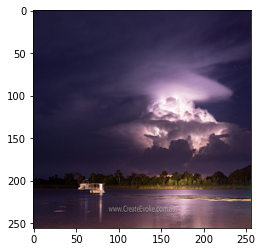

In [27]:
for images, labels in dataloader:
    plt.imshow(images[0].permute(1,2,0))
    break

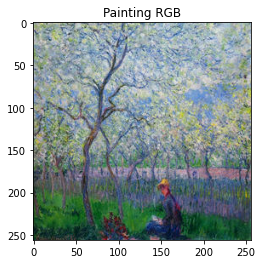

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


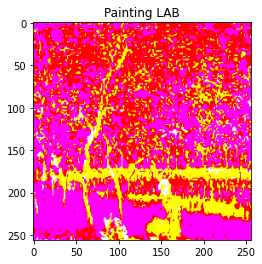

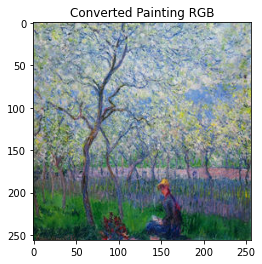

In [28]:
for images, labels in dataloader_1:
    plt.imshow(images[0].permute(1,2,0))
    plt.title('Painting RGB')
    plt.show()
    new_im = cv2.cvtColor(np.float32(images[0].permute(1,2,0)), cv2.COLOR_RGB2LAB)
    plt.imshow(new_im)
    plt.title('Painting LAB')
    plt.show()
    new_im = cv2.cvtColor(new_im, cv2.COLOR_LAB2RGB)
    plt.imshow(new_im)
    plt.title('Converted Painting RGB')
    plt.show()
    break

In [29]:
hue_shift = random.random()

In [ ]:
# train FE and RD
min_loss = float('inf')
for e in range(epoches):
    total_loss = 0.
    for image, label, in tqdm(dataloader):
        #for image_1, label_1, in tqdm(dataloader_1):
        ori_image = image
        #print('image.shape',image.shape)
        new_image = augment_image(image, hue_shift)
        #new_im = new_image
        new_im = torch.from_numpy(new_image)
        #image_1 = image_1.float().to(device)
        #new_img_LAB = cv2.cvtColor(np.float32(image_1.numpy()), cv2.COLOR_RGB2LAB)
        #plt.imshow(new_img_LAB)
        #plt.show()
        illu = get_illuminance(ori_image)
        #print('Illu', illu)
        illu = illu.double()
        #print('Illumination in main: ', illu.shape)
        palette = flat_pal
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        #print('Palette: ',palette.float().to(device))
        #print('Illu:', illu.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))
        #print(out.shape)
        optimizer.zero_grad()


        '''
        plt.imshow(new_im.permute(1,2,0))
        plt.show()
        print(out[0].shape)
        plt.imshow((out[0].permute(1,2,0)).detach().numpy())
        plt.show()
        temp = cv2.cvtColor(np.uint8((out[0].permute(1,2,0)).detach().numpy()), cv2.COLOR_LAB2RGB)
        plt.imshow(temp)
        plt.show()
        loss = criterion(torch.from_numpy(temp).float().to(device), new_im.float().to(device))
        '''


        #print('Out: ',out[0].shape)
        #print('New: ',new_im.shape)

        loss = criterion(out[0], new_im.float().to(device))
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    print(e, total_loss)

    if total_loss < min_loss:
        min_loss = total_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, "FE_RD.pth")

In [30]:
# load model from saved model file
state = torch.load("FE_RD.pth", map_location=torch.device('cpu'))
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

In [31]:
for image,label in tqdm(dataloader):
        ori_image = image
        hue_shift = random.random()
        new_image = augment_image(image, hue_shift)
        new_im = torch.from_numpy(new_image)
        illu = get_illuminance(ori_image)
        illu = illu.double()
        palette = flat_pal
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))
        break
        

  0%|          | 0/48 [00:00<?, ?it/s]


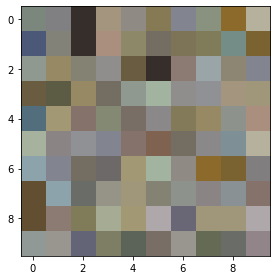

In [32]:
m, n = 10, 10
tt = np.array(t_rgb)
indices = np.random.randint(0, len(tt), size=(m, n))
io.imshow(tt[indices])

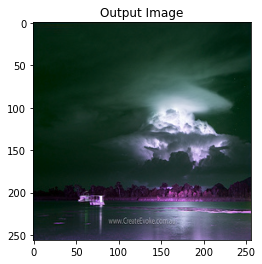

In [33]:
#out.shape
out = out[0].detach().cpu()
out = out.permute(1,2,0)
out = cv2.cvtColor(np.float32(out), cv2.COLOR_LAB2RGB)
plt.imshow(out)
plt.title("Output Image")
plt.show()

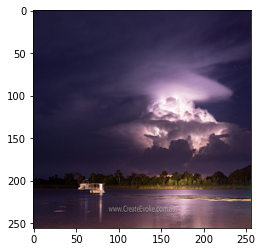

In [34]:
plt.imshow(ori_image[0].permute(1,2,0))

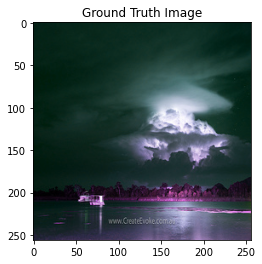

In [35]:
new_im = new_im.detach().cpu()
new_im = new_im.permute(1,2,0)
new_im = cv2.cvtColor(np.float32(new_im), cv2.COLOR_LAB2RGB)
plt.imshow(new_im)
plt.title("Ground Truth Image")
plt.show()

In [36]:
for image, label, in tqdm(dataloader):
    image_rgb = image
    break

  0%|          | 0/48 [00:00<?, ?it/s]


In [37]:
imageTorch = image_rgb[0]

In [38]:
imageTorch = ori_image[0]

In [39]:
temp_six.shape

(100, 3)

In [40]:

temp_six.dtype

dtype('int32')

In [41]:
palTorch = torch.from_numpy(temp_six)

In [42]:



imageTorch.shape

torch.Size([3, 256, 256])

In [43]:
imageTorch = imageTorch.permute(1,2,0)

In [44]:
imageTorch.shape

torch.Size([256, 256, 3])

In [45]:
imageTorch.shape

torch.Size([256, 256, 3])

In [46]:
palTorch = palTorch/255.0

In [47]:
palTorch.shape

torch.Size([100, 3])

In [48]:
result = torch.cdist(imageTorch, palTorch, p=2)

In [49]:
result.shape

torch.Size([256, 256, 100])

argMin = torch.argmin(result, dim=2, keepdim=True)

argMin.shape

argMin = argMin[:,:, 0]

#argMin = argMin.detach().numpy()

#argMin = argMin[:,:,0]

argMin.shape

temp = torch.zeros((256,256,3))

palTorch.shape

for i in range(256):
    for j in range(256):
        temp[i][j][:] = palTorch[argMin[i][j].item()]

temp

In [50]:
def show(img):
    npimg = img.numpy()
    plt.imshow(npimg, interpolation='nearest')

In [51]:
class PalNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(3,64)
        self.fc2 = nn.Linear(64,128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
    def forward(self, x):
        # define forward pass
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [52]:
pal_six = torch.from_numpy(temp_six)
pal_six.shape

torch.Size([100, 3])

In [53]:
palModel = PalNetwork()
tempPal = palModel(pal_six.float())
tempPal.shape

torch.Size([100, 512])

In [54]:
tp = tempPal/255

In [300]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(3):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(3):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, 100, 7),nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x

In [301]:
gen = GeneratorResNet((3,256,256),9)

In [302]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32,1)
        self.conv2 = nn.Conv2d(32, 64,1)
        self.conv3 = nn.Conv2d(64, 128,1)
        self.conv4 = nn.Conv2d(128, 256,1)
        self.conv5 = nn.Conv2d(256, 512,1)



    # x represents our data
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        
        x = self.conv5(x)
        x = F.relu(x)

        

        # Apply softmax to x
        output = F.log_softmax(x)
        return x

In [304]:
#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/trainB/2013-11-08 16:45:24.jpg')
p = transforms.Compose([transforms.Resize((256,256))])
pil_to_tensor = transforms.ToTensor()(p(pil_img)).unsqueeze_(0)
print(pil_to_tensor.shape)
result = gen(pil_to_tensor)
result.shape

torch.Size([1, 3, 256, 256])


torch.Size([1, 100, 256, 256])

In [305]:
pal_six.shape

torch.Size([100, 3])

In [306]:
result = result.permute(0,2,3,1)
result.shape

torch.Size([1, 256, 256, 100])

In [308]:
new = torch.matmul(result, pal_six.float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


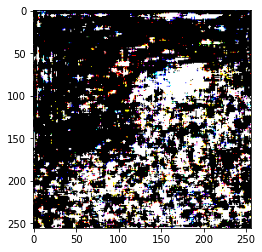

In [310]:
plt.imshow(new[0].detach().numpy())

In [127]:
result = result[0].permute(1,2,0)

In [128]:
result.shape

torch.Size([256, 256, 512])

torch.Size([1, 256, 256, 512])
torch.Size([100, 512])
(1, 256, 256, 100)


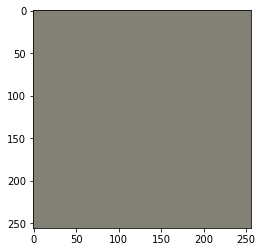

In [130]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """
    # make X at least 2d
    y = np.atleast_2d(X)
    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)
    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    # exponentiate y
    y = np.exp(y)
    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
    # finally: divide elementwise
    p = y / ax_sum
    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()
    return p


#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/trainB/2013-11-08 16:45:24.jpg')
p = transforms.Compose([transforms.Resize((256,256))])
pil_to_tensor = transforms.ToTensor()(p(pil_img)).unsqueeze_(0)
fake_A = gen(pil_to_tensor)
fake_A = fake_A.permute(0,2,3,1)
print(fake_A.shape)
print(tempPal.shape)





cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
# num_colours X rgb values
#pallette_col = np.random.randint(0,255, size=(26,3))
# batch_size x H X W X latent_space
#feat_im = np.random.rand(10,64,64,512)
# num_colours X latent_space
#feat_col = np.random.rand(pallette_col.shape[0],512)
# batch_size x H x W x num_colours 


feat_cos = cosine_sim([fake_A.detach().numpy(), tp.detach().numpy()])
print(feat_cos.shape)
x_latent = softmax(feat_cos, axis=-1)
x_fake = x_latent.dot(pal_six.detach().numpy()/255)
x_fake = torch.from_numpy(x_fake).float()
plt.imshow(x_fake[0])

In [103]:
index = np.argmax(feat_cos, axis = 3)

In [104]:
temp_latent = x_latent[0]

In [118]:
fake_A.shape

torch.Size([1, 3, 256, 256])

In [134]:
feat = torch.cdist(fake_A, tp)
print(feat.shape)

torch.Size([1, 256, 256, 100])


In [139]:
feat_cos.shape

(1, 256, 256, 100)

In [144]:
temp = np.zeros([256,256,3])
for i in range(256):
    for j in range(256):
        temp[i][j] = pal_six[np.argmax(temp_latent[i][j])]

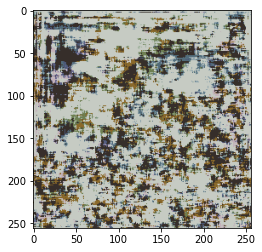

In [145]:
plt.imshow(np.uint8(temp))

In [147]:
def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    # type: (Tensor, float, bool, float, int) -> Tensor
    r"""
    Samples from the Gumbel-Softmax distribution (`Link 1`_  `Link 2`_) and optionally discretizes.

    Args:
      logits: `[..., num_features]` unnormalized log probabilities
      tau: non-negative scalar temperature
      hard: if ``True``, the returned samples will be discretized as one-hot vectors,
            but will be differentiated as if it is the soft sample in autograd
      dim (int): A dimension along which softmax will be computed. Default: -1.

    Returns:
      Sampled tensor of same shape as `logits` from the Gumbel-Softmax distribution.
      If ``hard=True``, the returned samples will be one-hot, otherwise they will
      be probability distributions that sum to 1 across `dim`.

    .. note::
      This function is here for legacy reasons, may be removed from nn.Functional in the future.

    .. note::
      The main trick for `hard` is to do  `y_hard - y_soft.detach() + y_soft`

      It achieves two things:
      - makes the output value exactly one-hot
      (since we add then subtract y_soft value)
      - makes the gradient equal to y_soft gradient
      (since we strip all other gradients)

    Examples::
        >>> logits = torch.randn(20, 32)
        >>> # Sample soft categorical using reparametrization trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=False)
        >>> # Sample hard categorical using "Straight-through" trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=True)

    .. _Link 1:
        https://arxiv.org/abs/1611.00712
    .. _Link 2:
        https://arxiv.org/abs/1611.01144
    """
    if eps != 1e-10:
        warnings.warn("`eps` parameter is deprecated and has no effect.")

    gumbels = -torch.empty_like(logits).exponential_().log()  # ~Gumbel(0,1)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [200]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """
    # make X at least 2d
    y = np.atleast_2d(X)
    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)
    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    # exponentiate y
    y = np.exp(y)
    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
    # finally: divide elementwise
    p = y / ax_sum
    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()
    return p


#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/trainB/2013-11-08 16:45:24.jpg')
p = transforms.Compose([transforms.Resize((256,256))])
pil_to_tensor = transforms.ToTensor()(p(pil_img)).unsqueeze_(0)
fake_A = gen(pil_to_tensor)
fake_A = fake_A.permute(0,2,3,1)
print(fake_A.shape)
print(tempPal.shape)





cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
# num_colours X rgb values
#pallette_col = np.random.randint(0,255, size=(26,3))
# batch_size x H X W X latent_space
#feat_im = np.random.rand(10,64,64,512)
# num_colours X latent_space
#feat_col = np.random.rand(pallette_col.shape[0],512)
# batch_size x H x W x num_colours 


feat_cos = cosine_sim([fake_A.detach().numpy(), tp.detach().numpy()])
print(feat_cos.shape)
x_latent = gumbel_softmax(torch.from_numpy(feat_cos))

torch.Size([1, 256, 256, 512])
torch.Size([100, 512])
(1, 256, 256, 100)


In [201]:
x_latent.shape

torch.Size([1, 256, 256, 100])

In [293]:
x_fake = torch.matmul(x_latent, pal_six.float())

In [295]:
for i in range(256):
    for j in range(256):
        x_fake[0][i][j][:] = pal_six[torch.argmax(x_latent[0][i][j])]

In [296]:
x_latent[0][i][j]

tensor([7.0934e-04, 2.7757e-03, 1.6441e-03, 4.3654e-04, 9.1555e-03, 1.7058e-03,
        2.2928e-03, 1.5109e-03, 7.5313e-03, 1.2089e-03, 1.2290e-02, 1.6503e-02,
        4.8206e-04, 6.0158e-04, 3.2669e-03, 2.5762e-03, 2.2289e-02, 3.8192e-01,
        6.6370e-04, 1.5060e-02, 1.7066e-03, 6.1683e-02, 1.7288e-03, 2.9119e-02,
        1.1141e-03, 5.4528e-03, 1.6301e-03, 2.4385e-03, 2.4403e-02, 2.2413e-03,
        1.0525e-03, 4.4953e-03, 1.6149e-03, 5.1094e-02, 3.1249e-03, 1.6310e-03,
        3.3085e-03, 3.2491e-03, 1.5101e-03, 3.6748e-03, 1.1335e-01, 7.9344e-03,
        2.8477e-03, 1.1619e-03, 2.2455e-03, 8.4871e-04, 1.7776e-03, 6.7007e-03,
        2.9609e-03, 4.0391e-03, 1.5707e-03, 1.4649e-03, 1.4817e-02, 1.3277e-03,
        3.6817e-04, 5.2375e-03, 2.8277e-03, 4.0249e-04, 2.1477e-03, 1.3329e-03,
        1.9582e-02, 7.1669e-04, 2.3378e-03, 1.0632e-03, 1.5698e-04, 5.5718e-04,
        5.8311e-03, 1.4013e-03, 8.2581e-03, 1.7195e-03, 1.0635e-02, 8.6679e-04,
        1.5928e-03, 9.3502e-03, 1.0577e-

In [297]:
x_fake[0][1][1]

tensor([159., 148., 127.])

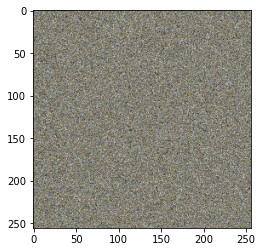

In [298]:
plt.imshow(np.uint8(x_fake[0].detach().numpy()))

In [ ]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """
    # make X at least 2d
    y = np.atleast_2d(X)
    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)
    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    # exponentiate y
    y = np.exp(y)
    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
    # finally: divide elementwise
    p = y / ax_sum
    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()
    return p

In [ ]:
cdist = torch.cdist(fake_A,tp, p=2)
x_latent1 = softmax(cdist.detach().numpy(),axis=-1)
x_fake1 = x_latent1.dot(pal_six/255)

In [ ]:
plt.imshow(x_fake1[0])

In [ ]:
pal_six.shape

In [ ]:
x_latent.shape

In [ ]:
tempLatent = x_latent[0]

In [ ]:
def argSoftmax(y_est):
    beta = 12
    #y_est = np.array([[1.1, 3.0, 1.1, 1.3, 0.8]])
    a = np.exp(beta*y_est)
    b = np.sum(np.exp(beta*y_est))
    softmax = a/b
    max = np.sum(softmax*y_est)
    pos = range(y_est.size)
    softargmax = np.sum(softmax*pos)
    return softargmax

## 3rd Task

In [63]:
temp_six.shape

(100, 3)

In [64]:
class PalNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
    def forward(self, x):
        # define forward pass
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [65]:
palNet = PalNetwork()

In [66]:
tempPal = palNet(pal_six.float())

In [67]:
tempPal.shape

torch.Size([100, 512])

In [68]:
class ImageEncoder(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
    def forward(self, x):
        # define forward pass
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [69]:
pal_six.shape

torch.Size([100, 3])

In [333]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )
        
        

    def forward(self, x):
        return x + self.block(x)
    
    
    
class PalNetwork(nn.Module):
    def __init__(self, in_features):
        # call constructor from superclass
        super(PalNetwork, self).__init__()
        channels = in_features.shape[1]
        # define network layers
        self.fc1 = nn.Linear(channels, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
    def forward(self, x):
        # define forward pass
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(3):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(3):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, 100, 7),nn.Tanh()]

        self.model = nn.Sequential(*model)
        
        
        self.palNet = nn.Sequential(
            nn.Linear(3,64),
            nn.Linear(64,128),
            nn.Linear(128,256),
            nn.Linear(256,512)
        )
  
    
    def softmax(self, X, theta = 1.0, axis = None):
        """
        Compute the softmax of each element along an axis of X.
        Parameters
        ----------
        X: ND-Array. Probably should be floats.
        theta (optional): float parameter, used as a multiplier
            prior to exponentiation. Default = 1.0
        axis (optional): axis to compute values along. Default is the
            first non-singleton axis.
        Returns an array the same size as X. The result will sum to 1
        along the specified axis.
        """
        # make X at least 2d
        y = np.atleast_2d(X)
        # find axis
        if axis is None:
            axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
        # multiply y against the theta parameter,
        y = y * float(theta)
        # subtract the max for numerical stability
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        # exponentiate y
        y = np.exp(y)
        # take the sum along the specified axis
        ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
        # finally: divide elementwise
        p = y / ax_sum
        # flatten if X was 1D
        if len(X.shape) == 1: p = p.flatten()
        return p
    
    def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        # type: (Tensor, float, bool, float, int) -> Tensor
        if eps != 1e-10:
            warnings.warn("`eps` parameter is deprecated and has no effect.")

        gumbels = -torch.empty_like(logits).exponential_().log()  # ~Gumbel(0,1)
        gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
        y_soft = gumbels.softmax(dim)

        if hard:
            # Straight through.
            index = y_soft.max(dim, keepdim=True)[1]
            y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
            ret = y_hard - y_soft.detach() + y_soft
        else:
            # Reparametrization trick.
            ret = y_soft
        return ret


    def main(self, y,z):
        # cosine similarity
        y = y.permute(0,2,3,1)
        cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
        # num_colours X rgb values
        #pallette_col = np.random.randint(0,255, size=(26,3))
        # batch_size x H X W X latent_space
        #feat_im = np.random.rand(10,64,64,512)
        # num_colours X latent_space
        #feat_col = np.random.rand(pallette_col.shape[0],512)
        # batch_size x H x W x num_colours
        #tempPal = PalNetwork(pal_six.float())
        
        feat_cos = cosine_sim([y.detach().numpy(), z.detach().numpy()])
        
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #output = cos(y,z)
        #x_distribution = F.softmax(output, dim = 1)
        
        #x_latent = softmax(feat_cos, axis=-1)
        x_latent = gumbel_softmax(torch.from_numpy(feat_cos))
       
        x_fake = torch.matmul(x_latent, pal_six.float())
        
        return x_fake.permute(0,3,1,2)
        
        

    def forward(self, x, pal):
        print(x.shape)
        print(pal.shape)
        x = self.model(x)
        #z = self.palNet(pal)
        #print(z.shape)
        #x = self.main(x,z)
        x = torch.matmul(x.permute(0,2,3,1), pal_six.float())
        print(x.shape)
        return x.permute(0,3,1,2)

In [334]:
pal_six.shape

torch.Size([100, 3])

In [335]:
input_shape = (3,256,256)
gen = GeneratorResNet(input_shape, 9)

In [336]:
genImage = gen(ori_image, pal_six.float())

torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])


In [337]:
genImage.shape

torch.Size([1, 3, 256, 256])

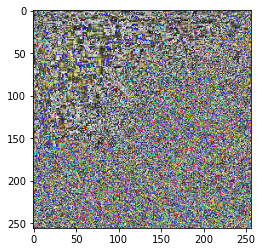

In [339]:
plt.imshow(np.uint8(genImage[0].permute(1,2,0).detach().numpy()))

In [340]:
class GeneratorResNet1(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet1, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [341]:
genImage.shape

torch.Size([1, 3, 256, 256])

In [342]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [343]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [344]:
dataset_name = 'monet2photo'
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [345]:
# Initialize generator and discriminator
input_shape = (3,256,256)
G_AB = GeneratorResNet1(input_shape, 9).float()
G_BA = GeneratorResNet(input_shape, 9).float()
D_A = Discriminator(input_shape).float()
D_B = Discriminator(input_shape).float()

In [346]:
epoch = 0
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 200
decay_epoch = 100
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))


# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs,epoch, decay_epoch).step
)


In [347]:
# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [348]:
dataset_name = 'monet2photo'
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [349]:
# Image transformations
transforms_ = [
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [350]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [351]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [352]:
# Training data loader
dataloader = DataLoader(
    ImageDataset("temp-A", transforms_=transforms_, unaligned=True),
    batch_size=1,
    shuffle=True,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset("temp-A", transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=1,
    shuffle=True,
)

In [353]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B,pal_six.float())
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)

In [ ]:
# ----------
#  Training
# ----------
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
sample_interval = 200
lambda_cyc = 10
lambda_id = 5
prev_time = time.time()
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)
         # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        #loss_id_A = criterion_identity(G_BA(real_A), real_A)
        #loss_id_B = criterion_identity(G_AB(real_B), real_B)

        #loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B,pal_six.float())
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B,pal_six.float())
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle #+ lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()
        
        print('Loss calculated')
        
         # -----------------------
        #  Train Discriminator A
        # -----------------------
        print('Disc A')
        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------
        print('Disc B')
        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        #print(prev_time)

        # Print log
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle:  %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                #loss_identity.item(),
                time_left,
            )
        )
        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    print('Now Saving Results')
    # Save model checkpoints
    torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
    torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
    torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
    torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))

torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
Loss calculated
Disc A
Disc B
[Epoch 5/200] [Batch 0/12] [D loss: 0.373950] [G loss: 47.569725, adv: 1.066580, cycle:  4.650315] ETA: 1 day, 11:38:15.200973
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
Loss calculated
Disc A
Disc B
[Epoch 5/200] [Batch 1/12] [D loss: 0.342471] [G loss: 36.216713, adv: 1.044580, cycle:  3.517213] ETA: 1 day, 11:58:14.789013
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch.Size([1, 256, 256, 3])
Loss calculated
Disc A
Disc B
[Epoch 5/200] [Batch 2/12] [D loss: 0.392834] [G loss: 63.212856, adv: 0.939557, cycle:  6.227330] ETA: 1 day, 10:58:39.244327
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])
torch

In [ ]:
G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (dataset_name, 0),map_location=torch.device('cpu')))
G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (dataset_name, 0),map_location=torch.device('cpu')))
D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (dataset_name, 0),map_location=torch.device('cpu')))
D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (dataset_name, 0),map_location=torch.device('cpu')))

(256, 256)
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.Size([100, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 256, 3])


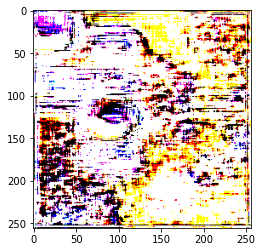

In [365]:
#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/testB/temp.jpg')
print(pil_img.size)  
p = transforms.Compose([transforms.Resize((256,256))])
pil_to_tensor = transforms.ToTensor()(p(pil_img)).unsqueeze_(0)
print(pil_to_tensor.shape) 
fake_A = G_BA(pil_to_tensor, pal_six.float())
save_image(fake_A, "unique.png", normalize=True)
plt.imshow(fake_A[0].permute(1,2,0).detach().numpy()*255)

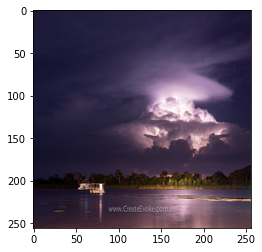

In [362]:
plt.imshow(pil_img)

In [ ]:
plt.imshow(ori_image[0].permute(1,2,0))

In [ ]:
input_shape = (3,256,256)
gen = GeneratorResNet(input_shape, 9)

In [ ]:
imEN = ImageEncoder()

In [ ]:
ori_image[0].shape

In [ ]:
genImage = gen(ori_image)

In [ ]:
genImage = genImage.permute(0,2,3,1)

In [ ]:
genImage.shape

In [ ]:
tempPal.shape

tempPal = torch.from_numpy(np.tile(tempPal.detach().numpy(),256))

tempPal = torch.reshape(tempPal,(256,100,512))

tempPal.shape

dist = torch.cdist(genImage, tempPal, p=2)

pal_six = pal_six/255.0
dist.shape

int(dist[0][0].min().item())

## New

In [ ]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """
    # make X at least 2d
    y = np.atleast_2d(X)
    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)
    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    # exponentiate y
    y = np.exp(y)
    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)
    # finally: divide elementwise
    p = y / ax_sum
    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()
    return p

In [ ]:
# cosine similarity
cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
# num_colours X rgb values
#pallette_col = np.random.randint(0,255, size=(26,3))
# batch_size x H X W X latent_space
#feat_im = np.random.rand(10,64,64,512)
# num_colours X latent_space
#feat_col = np.random.rand(pallette_col.shape[0],512)
# batch_size x H x W x num_colours
temp12 = tempPal.detach().numpy()
temp13 = genImage.detach().numpy()
print(temp12.shape)
print(temp13.shape)
feat_cos = cosine_sim([temp13,temp12])
x_latent = softmax(feat_cos, axis=-1)
x_fake = x_latent.dot(pal_six)
plt.imshow(x_fake[0].astype(np.uint8))

In [ ]:
def main():
    # cosine similarity
    cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
    # num_colours X rgb values
    pallette_col = np.random.randint(0,255, size=(26,3))
    # batch_size x H X W X latent_space
    feat_im = np.random.rand(10,64,64,512)
    # num_colours X latent_space
    feat_col = np.random.rand(pallette_col.shape[0],512)
    # batch_size x H x W x num_colours
    feat_cos = cosine_sim([feat_im, feat_col])
    x_latent = softmax(feat_cos, axis=-1)
    x_fake = x.dot(pallette_col)
    plt.imshow(x_fake[0].as_type(np.uint8))

In [ ]:
x_fake/255

In [ ]:
pal_six.shape

In [ ]:
x_latent = softmax(feat_cos, axis=-1)

In [ ]:
x_latent.shape

In [ ]:
x_fake = x_latent.dot(pal_six)

In [ ]:
x_fake.shape

In [ ]:
plt.imshow(x_fake[0])

In [ ]:
argMax = torch.argmax(torch.from_numpy(x_latent), dim=3, keepdim=True)

In [ ]:
argMax.shape

In [ ]:
for i in range(256):
    for j in range(256):
        temp[i,j,:] = pal_six[argMax[0][i][j].item()]

In [ ]:
plt.imshow(temp)

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet1(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet1, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(3):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(3):
            print(out_features)
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7),nn.Tanh()]

        self.model = nn.Sequential(*model)
    

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
orig = GeneratorResNet1(input_shape,9)

In [ ]:
genImage = orig(ori_image)

In [ ]:
genImage.shape

In [ ]:
plt.imshow(genImage[0].permute(1,2,0).detach().numpy())

In [ ]:
plt.imshow(x_fake[0])

In [ ]:
tempPal.shape

In [ ]:
for image,label in tqdm(dataloader):
        ori_image = image
        break

In [ ]:
plt.imshow(ori_image[0].permute(1,2,0))

In [ ]:
tempPal.shape

In [ ]:
genImage.shape

In [ ]:
# cosine similarity
cosine_sim = lambda x: x[0].dot(x[1].T)/ (np.linalg.norm(x[0]) * np.linalg.norm(x[1]))
# num_colours X rgb values
pallette_col = np.random.randint(0,255, size=(26,3))
# batch_size x H X W X latent_space
feat_im = np.random.rand(10,64,64,512)
# num_colours X latent_space
feat_col = np.random.rand(pallette_col.shape[0],512)
# batch_size x H x W x num_colours
print(feat_im.shape)
feat_cos = cosine_sim([feat_im, feat_col])
x_latent = softmax(feat_cos, axis=-1)
x_fake = x_latent.dot(pallette_col)
plt.imshow(x_fake[0]/255)